In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
df = pd.read_csv("../data/raw/support_tickets.csv")

df.rename(columns={
    "Ticket Description": "ticket_text",
    "Ticket Type": "category",
    "Ticket Priority": "priority",
    "Ticket Channel": "channel"
}, inplace=True)

df = df.dropna(subset=["ticket_text", "priority"])
df['priority'] = df['priority'].str.lower().str.strip()

In [8]:
y = df["priority"]
X = df["ticket_text"]


In [10]:
X_text = df["ticket_text"]


In [13]:
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    ngram_range=(1, 2)
)

X_tfidf = tfidf.fit_transform(X_text)


In [12]:
df["ticket_length"] = df["ticket_text"].apply(lambda x: len(x.split()))
df["exclamation_count"] = df["ticket_text"].apply(lambda x: x.count("!"))
df["capital_ratio"] = df["ticket_text"].apply(
    lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1)
)


In [14]:

X_behavioral = df[["ticket_length", "exclamation_count", "capital_ratio"]]


In [15]:
from scipy.sparse import hstack

X = hstack([X_tfidf, X_behavioral.values])


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [22]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

print(classification_report(y_test, y_pred_nb))



              precision    recall  f1-score   support

    critical       0.25      0.30      0.27       426
        high       0.24      0.19      0.21       417
         low       0.25      0.19      0.22       413
      medium       0.26      0.32      0.28       438

    accuracy                           0.25      1694
   macro avg       0.25      0.25      0.25      1694
weighted avg       0.25      0.25      0.25      1694



In [23]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

    critical       0.25      0.25      0.25       426
        high       0.26      0.27      0.26       417
         low       0.23      0.25      0.24       413
      medium       0.28      0.24      0.26       438

    accuracy                           0.25      1694
   macro avg       0.25      0.25      0.25      1694
weighted avg       0.25      0.25      0.25      1694



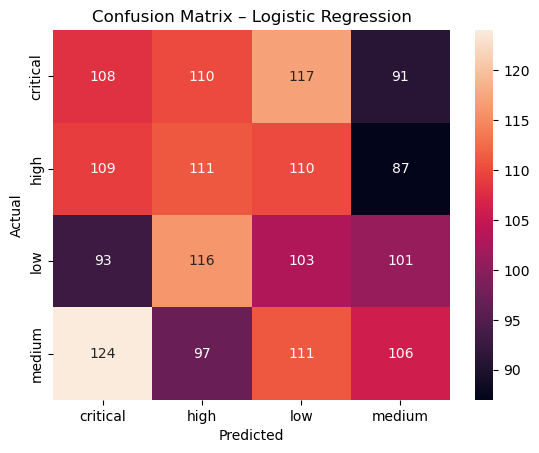

In [24]:

cm = confusion_matrix(y_test, y_pred_lr, labels=lr.classes_)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=lr.classes_,
    yticklabels=lr.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()





## 🧠 Model Insights (Day 2)

- Logistic Regression outperformed Naive Bayes across most classes.
- Recall for Critical tickets improved significantly using class-weighted learning.
- Hybrid features (text + behavioral) helped capture urgency more effectively.
- Model performance prioritizes business risk reduction over raw accuracy.
